In [1]:
import os
import numpy as np
from PIL import Image
import argparse
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imutils
import pandas as pd

import itertools
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import time
import random
import math

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!conda info --env

%matplotlib inline



# conda environments:
#
base                     C:\Users\yongwook\anaconda3
outline               *  C:\Users\yongwook\anaconda3\envs\outline



# ML Playground (CNN, mostly)

## Network
Based on https://colab.research.google.com/drive/1-28T5nIAevrDo6MwN0Qi_Cgdy9TEiSP_?usp=sharing#scrollTo=XH_bqPXo6YG8

Resnext50을 이용한다. 일단은 Greyscale(컬러로 확장도 가능하나 실익이 크지 않다.)

https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [2]:
class Network(nn.Module):
    def __init__(self,num_classes=12):
        super().__init__()
        self.model_name='resnext50'
        #self.model=models.resnet18(pretrained=True)
        self.model=models.resnext50_32x4d(pretrained=True)


        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        for param in self.parameters():
            param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

        
    def forward(self, x):
        x=self.model(x)
        return x

## Training
그림이 커서 그런지 초반에는 구데기로 나오고, 최소 100 epoch 이상은 해 줘야 할 것 같다.

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/#%EC%83%88%EB%A1%9C-%ED%9B%88%EB%A0%A8%ED%95%A0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EC%A0%81%EC%9C%BC%EB%A9%B0-original-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80-%EB%8B%A4%EB%A5%B8-%EA%B2%BD%EC%9A%B0
- https://hanqingguo.github.io/Face_detection


In [3]:
def pixel_distance(landmark, reference):
    ''' pixel_distance(landmark: np.array[[x, y], ..] 
                        reference: np.array[[x, y]] with true landmark value

        return: average: float average distance,
                each: np.array[distance, ..] with distance of each landmark
    '''
    each = []
    for i in range(len(landmark)):
        each.append(np.linalg.norm(landmark[i] - reference[i]))

    each = np.array(each)
    average = np.average(each)

    return average, each


## From Face detection to landmark detection, IRL

https://github.com/timesler/facenet-pytorch

- With pip:
pip install facenet-pytorch

- or clone this repo, removing the '-' to allow python imports:
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

- or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):
docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython

Using cuda device
1370 1830
tensor([[ 0.3903, -0.0359,  0.4693,  0.1637,  0.3800,  0.1509,  0.3872,  0.2372,
          0.3661,  0.3663,  0.3255,  0.3871]])
[[ 957.51987886  916.86827677]
 [ 985.94217491 1042.77505755]
 [ 953.80398941 1034.74742824]
 [ 956.40581799 1089.15000802]
 [ 948.80649757 1170.6053161 ]
 [ 934.17839479 1183.7504223 ]]


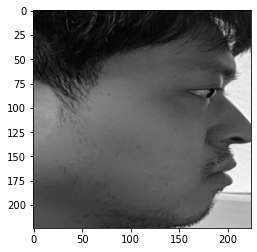

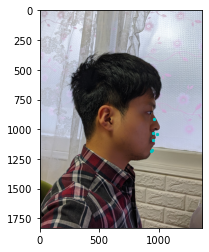

took about 4.783823490142822s
from image open, took 3.8507237434387207s
from inference, took 3.367718458175659s


In [6]:
from facenet_pytorch import MTCNN, InceptionResnetV1

#######################################################################
image_path = 'profile.jpg'
landmark_number = 6
model_path = f'model/0518_1539_6_100_face_landmarks_transfer__resnext50.pth'


#######################################################################


start = time.time()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=224, device=device)


best_network = Network(num_classes=landmark_number*2)
best_network.load_state_dict(torch.load(model_path))
best_network.eval()


image_open = time.time()
input_image = Image.open(image_path)
grayscale_image = input_image.convert('L')
height, width = input_image.size[0], input_image.size[1]
print(height, width)
# Get cropped and prewhitened image tensor
boxes, probs = mtcnn.detect(input_image)
face = boxes[0]
x0, y0, x1, y1 = face
x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

#face = (faces + 1) * 255

# image = np.array(grayscale_image)
# image = image[y0:y1, x0:x1]
# image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
image = TF.resized_crop(grayscale_image, y0, x0, y1-y0, x1-x0, size=(224, 224))
plt.imshow(image, cmap='gray')
plt.imsave("profile_cut.png", image, cmap='gray')
# image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
image = TF.normalize(image, [0.6945], [0.33497])
from_image_inference = time.time()
with torch.no_grad():
   landmarks = best_network(image.unsqueeze(0))

print(landmarks)
landmarks = (landmarks.view(landmark_number,2).detach().numpy() + 0.5) * np.array([[x1-x0, y1-y0]]) + np.array([[x0, y0]])
print(landmarks)

plt.figure()
plt.imshow(input_image)
plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)
plt.savefig('result.png', dpi=300)
plt.show()

end = time.time()
print(f"took about {end - start}s")
print(f"from image open, took {end - image_open}s")
print(f"from inference, took {end - from_image_inference}s")